# <center> Feature generation

In [1]:
%store -r __ipy
%store -r __da

In [2]:
__ipy

Helper ipython script loaded


In [3]:
__da

Basic Data Analysis tools was loaded


In [121]:
# Bayessian Optimization
from bayes_opt import BayesianOptimization
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error 

from hyperopt.pyll import scope 

In [4]:
root = 'data/'

In [5]:
weather_df = pd.read_csv("data/weather_train.csv")


weather_df['has_nan'] =  weather_df.isnull().progress_apply(lambda x: 1 if np.any(x) else 0, axis=1)
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], infer_datetime_format=False)
weather_df.fillna(0, inplace=True)
weather_df.to_pickle(root + 'weather_df.pkl')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139773/139773 [00:05<00:00, 26087.56it/s]


In [4]:
train_df = pd.read_pickle(root + 'train_df.pkl')
test_df = pd.read_pickle(root + 'test_df.pkl')

train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

In [5]:
train_df['age'] = train_df['year_built'].max() - train_df['year_built'] + 1
test_df['age'] = test_df['year_built'].max() - test_df['year_built'] + 1

In [6]:
%%time
from sklearn.preprocessing import LabelEncoder
import math

le = LabelEncoder()
train_df['primary_use'] = train_df['primary_use'].astype(str)
train_df['primary_use'] = le.fit_transform(train_df['primary_use']).astype(np.int8)

test_df['primary_use'] = test_df['primary_use'].astype(str)
test_df['primary_use'] = le.fit_transform(test_df['primary_use']).astype(np.int8)

train_df['floor_count'] = train_df['floor_count'].fillna(-999).astype(np.int16)
test_df['floor_count'] = test_df['floor_count'].fillna(-999).astype(np.int16)

train_df['year_built'] = train_df['year_built'].fillna(-999).astype(np.int16)
test_df['year_built'] = test_df['year_built'].fillna(-999).astype(np.int16)

train_df['age'] = train_df['age'].fillna(-999).astype(np.int16)
test_df['age'] = test_df['age'].fillna(-999).astype(np.int16)

train_df['cloud_coverage'] = train_df['cloud_coverage'].fillna(-999).astype(np.int16)
test_df['cloud_coverage'] = test_df['cloud_coverage'].fillna(-999).astype(np.int16) 


train_df['month_datetime'] = train_df['timestamp'].dt.month.astype(np.int8)
train_df['weekofyear_datetime'] = train_df['timestamp'].dt.weekofyear.astype(np.int8)
train_df['dayofyear_datetime'] = train_df['timestamp'].dt.dayofyear.astype(np.int16)
    
train_df['hour_datetime'] = train_df['timestamp'].dt.hour.astype(np.int8)  
train_df['day_week'] = train_df['timestamp'].dt.dayofweek.astype(np.int8)
train_df['day_month_datetime'] = train_df['timestamp'].dt.day.astype(np.int8)
train_df['week_month_datetime'] = train_df['timestamp'].dt.day/7
train_df['week_month_datetime'] = train_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
    
test_df['month_datetime'] = test_df['timestamp'].dt.month.astype(np.int8)
test_df['weekofyear_datetime'] = test_df['timestamp'].dt.weekofyear.astype(np.int8)
test_df['dayofyear_datetime'] = test_df['timestamp'].dt.dayofyear.astype(np.int16)
    
test_df['hour_datetime'] = test_df['timestamp'].dt.hour.astype(np.int8)
test_df['day_week'] = test_df['timestamp'].dt.dayofweek.astype(np.int8)
test_df['day_month_datetime'] = test_df['timestamp'].dt.day.astype(np.int8)
test_df['week_month_datetime'] = test_df['timestamp'].dt.day/7
test_df['week_month_datetime'] = test_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)

Wall time: 1min 3s


In [11]:
from tqdm.auto import tqdm
tqdm.pandas()

KEY = ['building_id', 'meter', 'site_id']
KEY_NAME = 'building_id__meter__key'

def to_key(train_df):
    le_key = LabelEncoder()
    train_df[KEY_NAME] = train_df[KEY].progress_apply(\
        lambda x: str(x['building_id']) + "_" + str(x['meter']) + "_" +   str(x['site_id']), axis=1)
    
    le_key.fit(train_df[KEY_NAME])
    train_df[KEY_NAME] = le_key.transform(train_df[KEY_NAME])
    train_df[KEY_NAME] = train_df[KEY_NAME].astype(np.int32)
    return train_df

train_df = to_key(train_df)
#test_df = to_key(test_df)

In [8]:
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

In [79]:
from tqdm.auto import tqdm 

In [7]:
train_df = pd.read_pickle(root + "temp.pkl")

In [89]:
feat_cols = ['building_id', 'meter', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'age', 'month_datetime', 'weekofyear_datetime',
       'dayofyear_datetime', 'hour_datetime', 'day_week', 'day_month_datetime',
       'week_month_datetime', 'building_id__meter__key']

categoricals =  ['building_id', 'meter','site_id',
       'primary_use', 'year_built', 'age', 'month_datetime', 'weekofyear_datetime',
       'dayofyear_datetime', 'hour_datetime', 'day_week', 'day_month_datetime',
       'week_month_datetime', 'building_id__meter__key']

In [90]:
full_train_df = train_df[feat_cols]
target = train_df['meter_reading_log1p']

In [91]:
from sklearn.model_selection import *
import lightgbm as lgb

def model_train():
    params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.4,
            'subsample_freq': 1,
            'learning_rate': 0.3,
            'num_leaves': 40,
            'feature_fraction': 0.75,
            'lambda_l1': 1,
            'lambda_l2': 1
    }
    
    folds = 2
    seed = 666

    kf = StratifiedKFold(n_splits=folds, shuffle=False, random_state=seed)

    models = []
    for train_index, val_index in tqdm(kf.split(full_train_df, full_train_df['building_id'])):
        train_X = full_train_df.iloc[train_index]
        val_X = full_train_df.iloc[val_index]
        train_y = target.iloc[train_index]
        val_y = target.iloc[val_index]
        lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
        lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
        gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=500,
                    valid_sets=(lgb_train, lgb_eval),
                    early_stopping_rounds=100,
                    verbose_eval = 100)
        models.append(gbm)        
    return models        

In [92]:
model_train()

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.695419	valid_1's rmse: 1.30668
Early stopping, best iteration is:
[26]	training's rmse: 0.821417	valid_1's rmse: 1.19296
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.684807	valid_1's rmse: 1.76938
Early stopping, best iteration is:
[5]	training's rmse: 1.15534	valid_1's rmse: 1.37261



## TSFresh

In [8]:
settings={
'standard_deviation': None,
 'variance': None,
 'skewness': None,
 'kurtosis': None,
 'absolute_sum_of_changes': None,

'last_location_of_maximum': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
'first_location_of_minimum': None,
'count_above_mean': None,
 'count_below_mean': None,
 'maximum': None,
 'minimum': None,

 'c3': [{'lag': 100}, {'lag': 2000}, {'lag': 3000},{'lag': 10000}],

'number_peaks': [{'n': 1}, {'n': 5},{'n': 100},{'n': 1000}],
'fft_coefficient': 
 [{'coeff': 0, 'attr': 'real'},
  {'coeff': 1, 'attr': 'real'},
  {'coeff': 2, 'attr': 'real'},
  {'coeff': 3, 'attr': 'real'},
  {'coeff': 4, 'attr': 'real'},

  {'coeff': 0, 'attr': 'imag'},
  {'coeff': 1, 'attr': 'imag'},
  {'coeff': 2, 'attr': 'imag'},
  {'coeff': 3, 'attr': 'imag'},
  {'coeff': 4, 'attr': 'imag'},
  {'coeff': 5, 'attr': 'imag'},

  {'coeff': 0, 'attr': 'abs'},
  {'coeff': 1, 'attr': 'abs'},
  {'coeff': 2, 'attr': 'abs'},
  {'coeff': 3, 'attr': 'abs'},
  {'coeff': 4, 'attr': 'abs'},
  {'coeff': 5, 'attr': 'abs'},

  {'coeff': 0, 'attr': 'angle'},
  {'coeff': 1, 'attr': 'angle'},
  {'coeff': 2, 'attr': 'angle'},
  {'coeff': 3, 'attr': 'angle'},
  {'coeff': 4, 'attr': 'angle'},
  {'coeff': 5, 'attr': 'angle'},
],
 'agg_linear_trend': [
     {'attr': 'rvalue', 'chunk_len': 500, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 500, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 500, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 500, 'f_agg': 'var'},
  {'attr': 'rvalue', 'chunk_len': 1000, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 1000, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 1000, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 1000, 'f_agg': 'var'},
  {'attr': 'rvalue', 'chunk_len': 5000, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 5000, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 5000, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 5000, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 500, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 500, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 500, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 500, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 1000, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 1000, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 1000, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 1000, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 5000, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 5000, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 5000, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 5000, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 500, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 500, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 500, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 500, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 1000, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 1000, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 1000, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 1000, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 5000, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 5000, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 5000, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 5000, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 500, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 500, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 500, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 500, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 1000, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 1000, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 1000, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 1000, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 5000, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 5000, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 5000, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 5000, 'f_agg': 'var'}],
 'index_mass_quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],

 'spkt_welch_density': [{'coeff': 2}, {'coeff': 5}, {'coeff': 8}],
 'ar_coefficient': [{'coeff': 0, 'k': 10},
  {'coeff': 1, 'k': 10},
  {'coeff': 2, 'k': 10},
  {'coeff': 3, 'k': 10},
  {'coeff': 4, 'k': 10}],

 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0},
  {'num_segments': 10, 'segment_focus': 1},
  {'num_segments': 10, 'segment_focus': 2},
  {'num_segments': 10, 'segment_focus': 3},
  {'num_segments': 10, 'segment_focus': 4},
  {'num_segments': 10, 'segment_focus': 5},
  {'num_segments': 10, 'segment_focus': 6},
  {'num_segments': 10, 'segment_focus': 7},
  {'num_segments': 10, 'segment_focus': 8},
  {'num_segments': 10, 'segment_focus': 9}],
 'ratio_beyond_r_sigma': [{'r': 0.5},
  {'r': 1},
  {'r': 1.5},
  {'r': 2},
  {'r': 2.5},
  {'r': 3},
  {'r': 5},
  {'r': 6},
  {'r': 7},
  {'r': 10}],
'max_langevin_fixed_point': [{'m': 3, 'r': 30}],
    'change_quantiles': [{'ql': 0.0, 'qh': 0.2, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'}]

}

In [12]:
import matplotlib.pyplot as plt
import lightgbm as lgb
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
import numpy as np
import pandas as pd
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters ,ComprehensiveFCParameters
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
import timeit
import seaborn as sns
import sys
import time
from tqdm import tqdm
import warnings
from tsfresh.utilities.dataframe_functions import make_forecasting_frame


In [41]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,age,month_datetime,weekofyear_datetime,dayofyear_datetime,hour_datetime,day_week,day_month_datetime,week_month_datetime,building_id__meter__key,meter_reading_log1p
103,105,0,2016-01-01,23.30,1,0,50623,-999,5,3.80,...,-999,1,53,1,0,4,1,1,94,3.19
104,106,0,2016-01-01,0.37,1,0,5374,-999,4,3.80,...,-999,1,53,1,0,4,1,1,105,0.32
105,106,3,2016-01-01,0.00,1,0,5374,-999,4,3.80,...,-999,1,53,1,0,4,1,1,106,0.00
106,107,0,2016-01-01,175.18,1,0,97532,2005,10,3.80,...,13,1,53,1,0,4,1,1,128,5.17
107,108,0,2016-01-01,91.27,1,0,81580,1913,5,3.80,...,105,1,53,1,0,4,1,1,148,4.52


**Test features**

In [50]:
n_samples = 100000
train_t = train_df[:n_samples]

def tsfresh_time(sett, column_sort, column_value):
    for f, param in tqdm(sett.items()):
        res.loc[f, "feature"] = f
        fc_dict = {f:param}
        t = timeit.timeit(lambda : extract_features(train_t, 
                         column_id=KEY_NAME,
                         column_sort=column_sort,
                         column_value=column_value,
                         n_jobs=12, 
                         default_fc_parameters=fc_dict, 
                         disable_progressbar=True), 
                         number=3)
        
        res.loc[f, "t_abs"] = t
    return res

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [02:54<00:00,  7.29s/it]


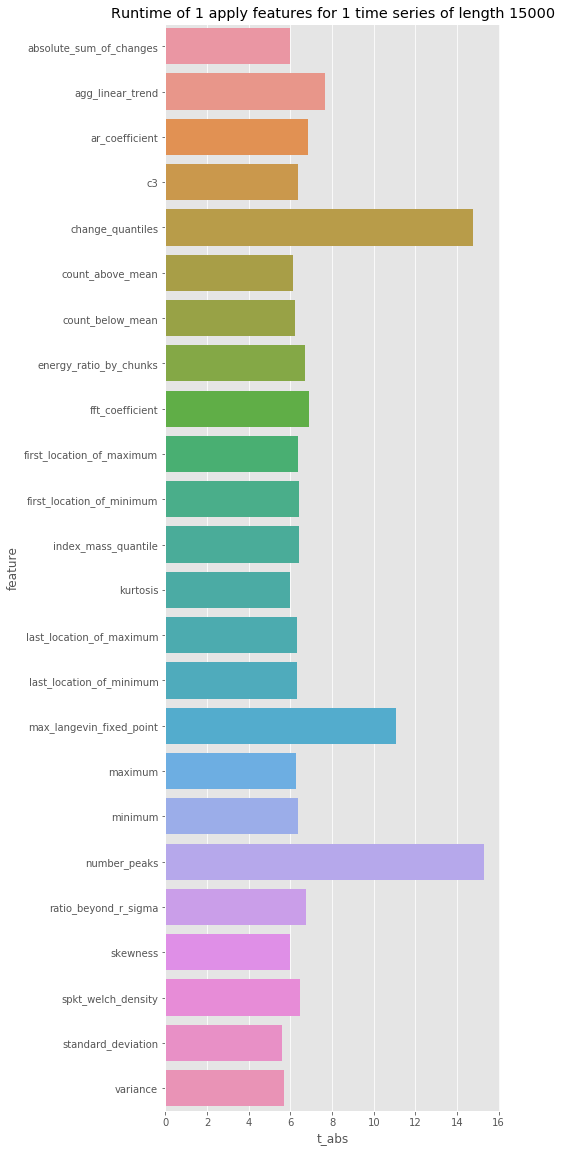

In [51]:
res=pd.DataFrame()
res=tsfresh_time(settings, 'timestamp', 'meter_reading')
res["feature"] = res.feature.astype(str)
res = res.sort_values(by="feature")

plt.figure(figsize=(6, 20))
sns.barplot(y="feature", x="t_abs", data=res)
plt.title("Runtime of 1 apply features for 1 time series of length %d"  % n_samples)
plt.show()

In [72]:
train_df = train_df.reset_index(drop=True)

In [81]:
train_df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'age', 'month_datetime', 'weekofyear_datetime',
       'dayofyear_datetime', 'hour_datetime', 'day_week', 'day_month_datetime',
       'week_month_datetime', 'building_id__meter__key',
       'meter_reading_log1p'],
      dtype='object')

In [118]:
import numpy as np
import time
from sklearn.model_selection import TimeSeriesSplit
tscv = KFold(n_splits=5)

start = time.time()

X = train_df[:n_samples]

def ts_features(train1, column_sort, column_value, settings):
    X=extract_features(train1, 
                     column_id=KEY_NAME,
                     column_sort=column_sort,
                     column_value=column_value,
                     default_fc_parameters=settings,
                     #impute_function= impute,
                     disable_progressbar=True,
                     show_warnings=True)
    return X


X_filtered = pd.DataFrame()

for i, (train_index, test_index) in tqdm(enumerate(tscv.split(X))):
    X_train = X.loc[train_index] 
    features = ts_features(X_train, 'hour_datetime', 'meter_reading',  settings)
    X_filtered = pd.concat((X_filtered, features.add_suffix(f'_{i}')), axis=1)
    
#X_filtered=X_filtered.reset_index().drop(['id'], axis=1)

print(X_filtered.shape)

end = time.time()
print("Time",end - start)




0it [00:00, ?it/s]

(2203, 146)
(2203, 146)





1it [00:11, 11.75s/it]

(2203, 146)
(2204, 292)





2it [00:23, 11.76s/it]

(2204, 146)
(2204, 438)





3it [00:35, 11.74s/it]

(2204, 146)
(2204, 584)





4it [00:47, 11.77s/it]

(2203, 146)
(2204, 730)





5it [00:58, 11.77s/it]


(2204, 730)
Time 58.85410237312317


In [ ]:
time_cols = ['month_datetime', 'weekofyear_datetime',
             'dayofyear_datetime', 'hour_datetime', 
             'day_week', 'day_month_datetime',
             'week_month_datetime']

In [162]:
-np.inf

-inf

In [163]:
def ts_features(train1, column_sort, column_value, settings):
    X=extract_features(train1, 
                     column_id=KEY_NAME,
                     column_sort=column_sort,
                     column_value=column_value,
                     default_fc_parameters=settings,
                     #impute_function= impute,
                     disable_progressbar=True,
                     show_warnings=True)
    return X

def generate_ts_features(X, y_col_name, time_cols, k_folds=5):
    tscv = KFold(n_splits=k_folds)
    
    start = time.time()

    X_filtered = pd.DataFrame()

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train = X.loc[train_index]
        for time_col in time_cols:         
            features = ts_features(X_train, time_col, y_col_name,  settings)
            
            for col in features.columns:
                features[col] = features[col].astype(np.float16)
            
            X_filtered = pd.concat((X_filtered, features.add_suffix(f'_{i}')), axis=1)
    
    X_filtered = X_filtered.replace([np.inf, -np.inf, np.nan], 0)
    impute(X_filtered)
    
    end = time.time()
    print("Time",end - start)
    
    return X_filtered


def generate_and_merge(X_train, X_test=None):
    features = generate_ts_features(X, 'meter_reading', ['hour_datetime'], k_folds=6)
    
    X_train = X_train.merge(features, how='left', left_on=KEY_NAME, right_on='id')
    
    if X_test:
        X_test = X_test.merge(features, how='left', left_on=KEY_NAME, right_on='id')
    
    return X_train, X_test

In [143]:
import numpy as np
import time
from sklearn.model_selection import TimeSeriesSplit

start = time.time()

X = train_df[:n_samples]
features = generate_ts_features(X, 'meter_reading', ['hour_datetime'], k_folds=6)

end = time.time()
print("Time",end - start)


Time 70.06717586517334
Time 70.06917119026184


In [134]:
feat_cols = ['building_id', 'meter', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'age', 'month_datetime', 'weekofyear_datetime',
       'dayofyear_datetime', 'hour_datetime', 'day_week', 'day_month_datetime',
       'week_month_datetime', KEY_NAME]

categoricals =  ['building_id', 'meter','site_id',
       'primary_use', 'year_built', 'age', 'month_datetime', 'weekofyear_datetime',
       'dayofyear_datetime', 'hour_datetime', 'day_week', 'day_month_datetime',
       'week_month_datetime', KEY_NAME]

In [ ]:
full_train_df = train_df.drop('timestamp', axis=1)
target = train_df['meter_reading']

In [164]:
from tqdm.auto import tqdm

folds = 12
def lgbm_cross_validation(params):
    seed = 42
    
    kf = KFold(n_splits=folds)
    total_loss = []
    
    for train_index, val_index in kf.split(full_train_df, full_train_df['building_id']):
        
        train_X = full_train_df.loc[train_index, feat_cols]
        val_X = full_train_df.loc[val_index, feat_cols]
        train_y = target.iloc[train_index]
        val_y = target.iloc[val_index]
        

        ###
        
        train_X, val_X = generate_and_merge(train_X, val_X)
        
        ###
        
        lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
        lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
        lgbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=500,
                    valid_sets=(lgb_train, lgb_eval),
                    early_stopping_rounds=100,
                    verbose_eval = 0)
        
        pred_y = lgbm.predict(val_X)
        mse = np.sqrt(mean_squared_error((val_y), (pred_y)))
        total_loss.append(mse)

    return {'loss': np.mean(total_loss), 'status': STATUS_OK, 'params': params }

def optimize_lgbm(max_evals=1000):
    space = {
        'metric': {'rmse'},
        'num_leaves': scope.int(hp.quniform('num_leaves', 30, 150, 1)),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'min_data_in_leaf': scope.int(hp.qloguniform('min_data_in_leaf', 0, 6, 1)),
        'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
        'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
        'min_child_weight': hp.loguniform('min_child_weight', -16, 5), #also aliases to min_sum_hessian
        'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
        'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    }
    
    trials = Trials()
    best = fmin(fn=lgbm_cross_validation,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials,
                verbose= 1)

    # find the trial with lowest loss value. this is what we consider the best one
    idx = np.argmin(trials.losses())
    print(idx)

    print(trials.trials[idx])
    # these should be the training parameters to use to achieve the best score in best trial
    params = trials.trials[idx]["result"]["params"]
    
    print(params)
    return params

In [ ]:
%%notify -m "Hyperopt execution was finished"

hp_params = optimize_lgbm(2)
hp_params








  0%|                                                                                                                                                                                                                                  | 0/2 [00:00<?, ?it/s, best loss: ?]

In [ ]:
train.to_pickle(root+'train.pkl')
val.to_pickle(root+'val.pkl')